In [18]:
import pandas as pd
import numpy as np
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import helper_functions
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from pydlv import dl_generator, dl_model_4, dl_plotter
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

helper = helper_functions.HelperFunctions()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
data_path = 'C:/Users/Arkady/Google Drive/data/beyond_the_reach'
figure_path = 'C:/Users/Arkady/Dropbox/Research/Journal papers/2019 Beyond reach/figures'

figure_format = '.png'

index=['subj_id', 'task', 'trial_no']

choices = pd.read_csv(os.path.join(data_path, 'choices_processed.txt'))
dynamics = pd.read_csv(os.path.join(data_path, 'dynamics_processed.txt'))

choices = choices.set_index(index, drop=False)
dynamics = dynamics.set_index(index, drop=False)

dynamics = dynamics.join(choices.choice)

dynamics['lambda_q'] = choices['lambda_q']
dynamics['Delta_q'] = choices['Delta_q']

In [20]:
dynamics_walking = dynamics.loc[dynamics.task=='walking', :]
dynamics_mouse = dynamics.loc[dynamics.task=='mouse', :]

choices_walking = choices.loc[choices.task=='walking', :]
choices_mouse = choices.loc[choices.task=='mouse', :]

Just in case, calculate normalized trajectories

In [44]:
dynamics_norm = dynamics
walking_x_lim = dynamics_walking.groupby(dynamics_walking.index.names).last().x.abs().mean()
walking_y_lim = dynamics_walking.groupby(dynamics_walking.index.names).last().y.mean()

mouse_x_lim = dynamics_mouse.groupby(dynamics_mouse.index.names).last().x.abs().mean()
mouse_y_lim = dynamics_mouse.groupby(dynamics_mouse.index.names).last().y.mean()

dynamics_norm.loc[dynamics_norm.task=='walking', ['x', 'vx']] /= walking_x_lim
dynamics_norm.loc[dynamics_norm.task=='walking', ['y', 'vy']] /= walking_x_lim
dynamics_norm.loc[dynamics_norm.task=='mouse', ['x', 'vx']] /= mouse_x_lim
dynamics_norm.loc[dynamics_norm.task=='mouse', ['y', 'vy']] /= mouse_x_lim

# Mean trajectories

In [23]:
choices[choices.choice=='LL'].Delta.quantile([0.0, 0.33, 0.66, 1])

0.00   -0.940000
0.33    0.031250
0.66    0.218750
1.00    0.636364
Name: Delta, dtype: float64

In [24]:
choices[choices.choice=='SS'].Delta.quantile([0.0, 0.33, 0.66, 1])

0.00   -0.981818
0.33   -0.500000
0.66   -0.156250
1.00    0.635294
Name: Delta, dtype: float64

In [37]:
# ['Delta'].transform(lambda x: pd.qcut(x, q=3, labels=['Low', 'Medium', 'High']))

# dynamics = dynamics[choices.is_staircase]
# choices = choices[choices.is_staircase]
# choices['Delta_q'] = choices.groupby(['task'])['Delta'].transform(
#                      lambda x: pd.qcut(x.rank(method='first'), q=3, labels=['Low', 'Medium', 'High']))
# choices.Delta = abs(choices.Delta)

# choices['Delta_q'] = pd.cut(choices.Delta, 5, labels=np.arange(5)+1)
# dynamics['Delta_q'] = choices['Delta_q']

# dynamics_walking = dynamics.loc[dynamics.task=='walking', :]
# dynamics_mouse = dynamics.loc[dynamics.task=='mouse', :]

# choices_walking = choices.loc[choices.task=='walking', :]
# choices_mouse = choices.loc[choices.task=='mouse', :]

In [25]:
def get_average_trajectories(dynamics, variables):
    cols = dynamics.index.names + variables    
    dynamics_transposed = dynamics.groupby(by = cols). \
                    apply(lambda x: x.loc[:, ['x', 'y']].reset_index(drop=True).T)
    cols += ['x/y']
    dynamics_transposed.index.names = cols
    
    subj_mean_traj = dynamics_transposed.groupby(level=variables + ['x/y']).apply(np.mean).stack()
    
    subj_mean_traj.index.names = variables + ['x/y', 't']
    subj_mean_traj = subj_mean_traj.unstack('x/y')
    return subj_mean_traj

mean_traj_walking = get_average_trajectories(dynamics_walking, ['choice', 'Delta_q'])
mean_traj_mouse = get_average_trajectories(dynamics_mouse, ['choice', 'Delta_q'])

mean_traj_walking_no_com = get_average_trajectories(dynamics_walking[~choices_walking.is_com], 
                                                    ['choice', 'Delta_q'])
mean_traj_mouse_no_com = get_average_trajectories(dynamics_mouse[~choices_mouse.is_com], 
                                                  ['choice', 'Delta_q'])

In [48]:
def plot_mean_trajectories(mean_trajectories, var='lambda_q', plot_bar=False):
    sns.set_palette('viridis', n_colors=10)
    sns.set_context("notebook", font_scale=2.3)
    fig, ax = plt.subplots(1, figsize=(10, 10))

    ax.set_aspect(1, adjustable='datalim')             
    
    colors = {'LL': {'Low': 'C4',
                     'Medium': 'C2',
                     'High': 'C0'},
              'SS': {'Low': 'C9',
                     'Medium': 'C7',
                     'High': 'C5'},}

    for name, group in mean_trajectories.groupby(['choice', var]):
        ax.plot(mean_trajectories.loc[name].x, mean_trajectories.loc[name].y, 
                lw=4, color=colors[name[0]][name[1]])
    ax.text(s='Larger \nbut later', x=0.85, y=1.05, 
            horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    ax.text(s='Smaller \nbut sooner', x=0.15, y=1.05, 
            horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    
    if plot_bar:
        x_bar = [-0.2, 0.2]
        y_bar = -0.05
        ax.plot(x_bar, [y_bar, y_bar], lw=5, color='grey')
    
    LL_lines = [Line2D([0], [0], color=color, lw=4) for color in colors['LL'].values()]
    SS_lines = [Line2D([0], [0], color=color, lw=4) for color in colors['SS'].values()]

    LL_legend = ax.legend(LL_lines, ['Low $\Delta$', 'Medium $\Delta$', 'High $\Delta$'], 
                          title='LL choices', loc='lower right')        
    SS_legend = ax.legend(SS_lines, ['Low $\Delta$', 'Medium $\Delta$', 'High $\Delta$'], 
                          title='SS choices', loc='lower left')
    ax.add_artist(LL_legend)
    ax.add_artist(SS_legend)
    
    return ax

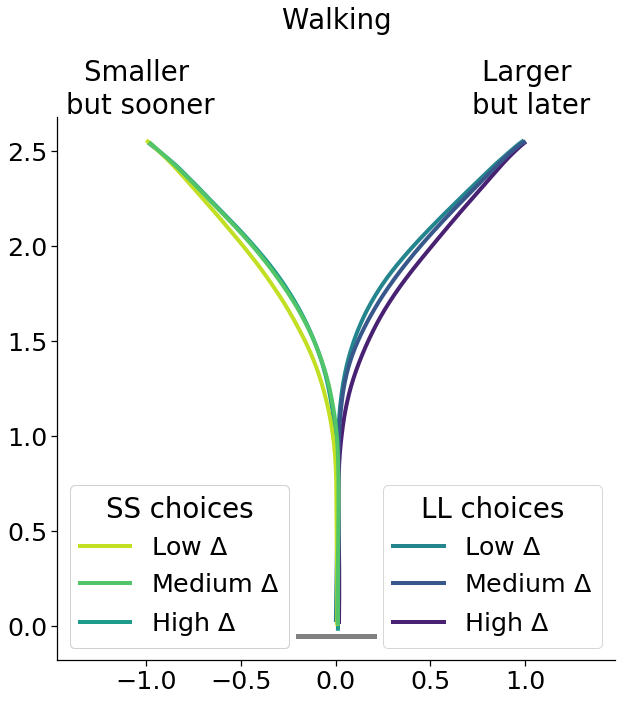

In [49]:
plot_mean_trajectories(mean_traj_walking, var='Delta_q', plot_bar=True)
plt.title('Walking', y=1.15)
plt.savefig(os.path.join(figure_path, 'mean_traj_walking'+figure_format), bbox_inches = 'tight')

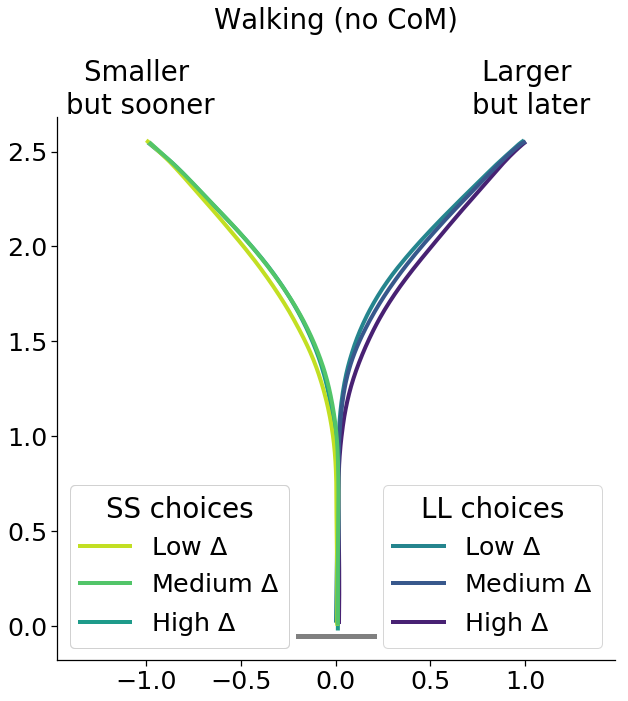

In [50]:
plot_mean_trajectories(mean_traj_walking_no_com, var='Delta_q', plot_bar=True)
plt.title('Walking (no CoM)', y=1.15)
plt.savefig(os.path.join(figure_path, 'mean_traj_walking_no_com'+figure_format), bbox_inches = 'tight')

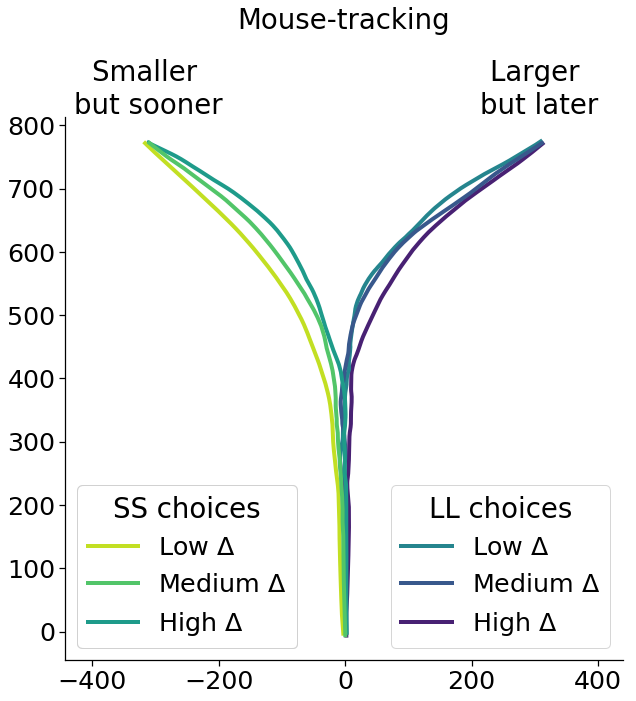

In [51]:
plot_mean_trajectories(mean_traj_mouse, var='Delta_q')
plt.title('Mouse-tracking', y=1.15)
plt.savefig(os.path.join(figure_path, 'mean_traj_mouse'+figure_format), bbox_inches = 'tight')

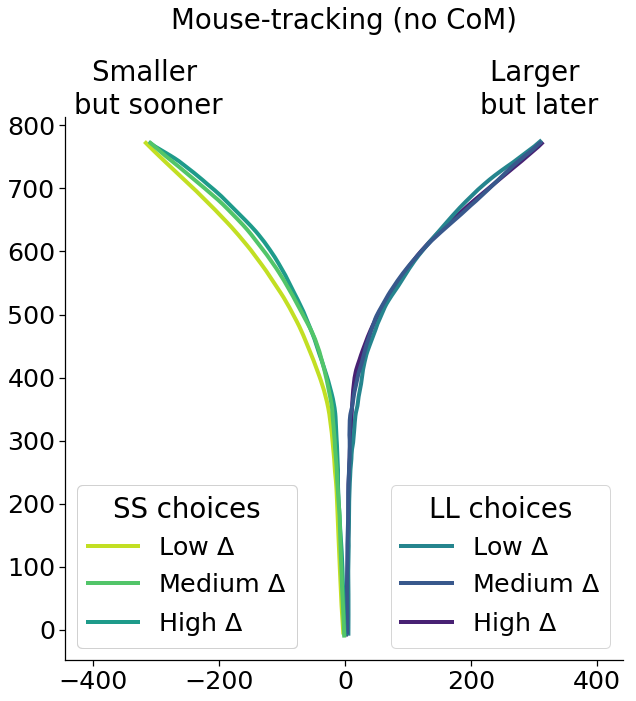

In [52]:
plot_mean_trajectories(mean_traj_mouse_no_com, var='Delta_q')
plt.title('Mouse-tracking (no CoM)', y=1.15)
plt.savefig(os.path.join(figure_path, 'mean_traj_mouse_no_com'+figure_format), bbox_inches = 'tight')

How much trajectories are averaged in these plots?

In [53]:
choices.groupby(['task', 'choice', 'Delta_q']).size()

task     choice  Delta_q
mouse    LL      High       334
                 Low        318
                 Medium     330
         SS      High       485
                 Low        578
                 Medium     445
walking  LL      High       334
                 Low        373
                 Medium     314
         SS      High       466
                 Low        495
                 Medium     469
dtype: int64

# Decision landscapes

In [21]:
def get_dlv_params(trajs, dlg):
    start_x = trajs.groupby(trajs.index.names).first().x.mean()
    start_y = trajs.groupby(trajs.index.names).first().y.mean()
    
    stim_x = trajs.groupby(trajs.index.names).last().x.abs().mean()
    stim_y = trajs.groupby(trajs.index.names).last().y.mean()
    
    trajs.loc[:, ['x', 'y']] -= [start_x, start_y]
    trajs.loc[:, ['x', 'y', 'vx', 'vy']] /= [stim_x, stim_y, stim_x, stim_y]
    
    params = dlg.fit_dl_mult_traj(trajs, index_cols = trajs.index.names)    
    return params

def plot_dlv(dlp, dlg, params, color):    
    x, y, dl = dlg.get_model_dl(params.loc[:, dlg.model.get_param_names()].values[0])
    dlp.plot_surface(x, y, dl, color=color, alpha=0.8, plot_marble=False)

In [19]:
choices_walking['Delta_q'] = pd.qcut(choices.Delta, q=3, labels=['Low', 'Medium', 'High'])

model = dl_model_4.DLModel4()           
dlg = dl_generator.DLGenerator(model)

low_params = get_dlv_params(trajs=dynamics_walking[choices_walking['Delta_q']=='Low'], dlg=dlg)
medium_params = get_dlv_params(trajs=dynamics_walking[choices_walking['Delta_q']=='Medium'], dlg=dlg)
high_params = get_dlv_params(trajs=dynamics_walking[choices_walking['Delta_q']=='High'], dlg=dlg)

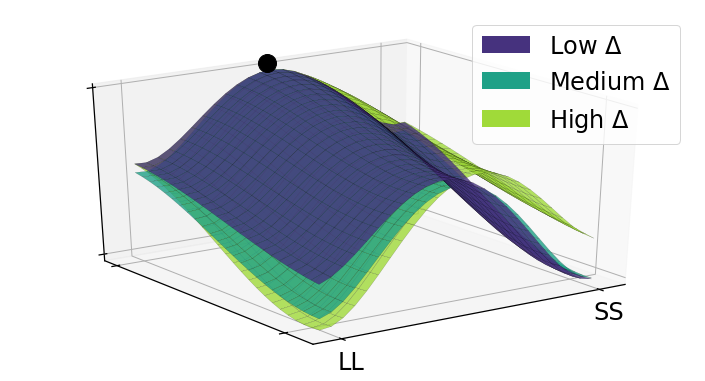

In [22]:
sns.set_palette('viridis')

dlp = dl_plotter.DLPlotter(azim=55)

plot_dlv(dlp, dlg, low_params, color='C0')
plot_dlv(dlp, dlg, medium_params, color='C3')
plot_dlv(dlp, dlg, high_params, color='C5')

dlp.add_legend(['C0', 'C3', 'C5'], labels=['Low $\Delta$', 'Medium $\Delta$', 'High $\Delta$'])
dlp.ax.set_xlabel('')
dlp.ax.set_ylabel('')

# dlp.ax.text(0.95, 1, -0.65, "LL", color='k', fontdict={'fontsize': 24})
# dlp.ax.text(-0.9, 1, -0.65, "SS", color='k', fontdict={'fontsize': 24})

dlp.ax.set_xticks([-1, 1])
dlp.ax.set_xticklabels(['SS', 'LL'], fontdict={'fontsize': 24})
dlp.ax.set_yticks([0, 1])
dlp.ax.set_yticklabels([])
# dlp.ax.set_zticks([0, -0.6])
dlp.ax.set_zticklabels([])

dlp.ax.plot([0.0], [0.], [0.02], marker='o', markersize=18, color='black')

plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'dlv_delta'+figure_format))

# Posterior plots

In [7]:
sns.set_palette('viridis')
sns.set_context("notebook", font_scale=1.2)

In [6]:
def plot_posterior_kde(posterior_samples, colors, alpha, ax):
    for choice in ['SS', 'LL']:
        samples = posterior_samples.loc[posterior_samples.choice==choice, 'beta']
        kde = gaussian_kde(samples)
        x_grid = np.linspace(samples.min(), samples.max(), 51)

        ax.plot(x_grid, kde(x_grid), color=colors[choice], alpha=alpha)

        ax.fill_between(x_grid, kde(x_grid), color=colors[choice], alpha=alpha,
                        where=(x_grid>samples.quantile(0.025))&(x_grid<samples.quantile(0.975)))

def plot_posterior_comparison(iv, task, dv, exclude_com, colors, ax):
    file_name = 'posterior_csv/%s/posterior_%s%s_%s.csv' % (iv, task, '_no_com' if exclude_com else '', dv)
    posterior_samples = (pd.read_csv(file_name)
                             .filter(regex=('b_choice.*:%s' % (iv)))
                             .stack()
                             .reset_index()
                             .drop('level_0', axis=1)
                             .rename(index=str, columns={'level_1': 'choice', 0: 'beta'}))
    
    # TODO: that's a dirty trick, replace 8:10 with a proper regex!
    posterior_samples['choice'] = posterior_samples['choice'].str[8:10]
    alpha = 0.3 if exclude_com else 0.9
    plot_posterior_kde(posterior_samples, colors, alpha, ax)
    
    x_max = 1.1*max(abs(posterior_samples.beta))
    ax.set_xlim((-x_max, x_max))
    ax.set_xlabel(r'$b_{\%s}$' % (iv))
    ax.set_ylabel('pdf')

def plot_all_posteriors(iv, axes, legend=True):
    colors={'LL': 'C0', 'SS': 'C4'}
    
    i = 0
    for task in ['walking', 'mouse']:
        for dv in ['max_d', 'RT']:
            ax = axes.flatten()[i]            
            plot_posterior_comparison(iv, task, dv, exclude_com=True, colors=colors, ax=ax)
            plot_posterior_comparison(iv, task, dv, exclude_com=False, colors=colors, ax=ax)
            ax.set_title(task + ' ' + dv.replace('_', '-'))
            ax.xaxis.set_major_locator(plt.MaxNLocator(5))
            
            i+=1
    
    legend_elements = [Patch(facecolor=colors[choice], label=choice) for choice in ['SS', 'LL']]

    if legend:
        fig.legend(handles=legend_elements, title='choice', loc='center left', 
                   bbox_to_anchor=(0.9, 0.8), ncol=1, frameon=False)
    plt.tight_layout(pad=1.1, w_pad=0.1, h_pad=0.1)

    plt.savefig(os.path.join(figure_path, 'posterior_' + iv + figure_format), dpi=300)

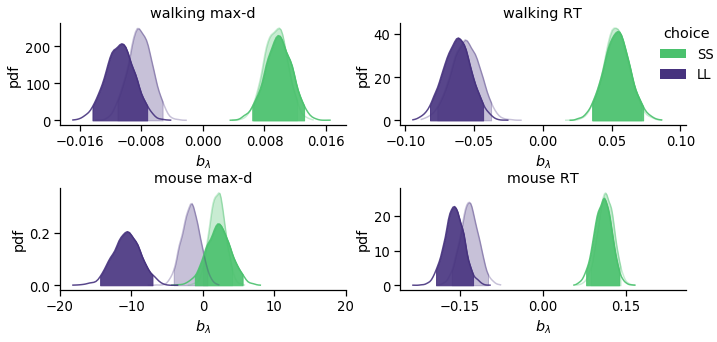

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(10,5))
plot_all_posteriors(iv='lambda', axes=axes)

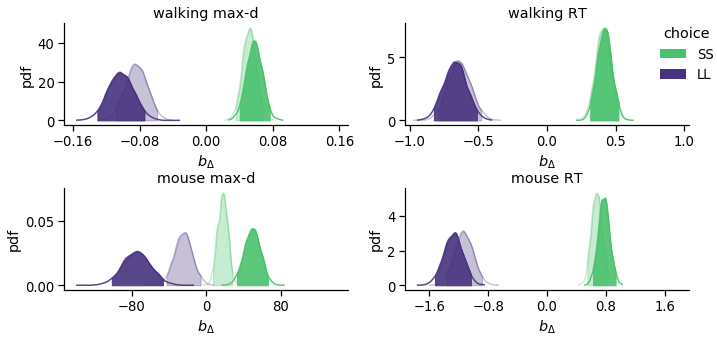

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(10,5))
plot_all_posteriors(iv='Delta', axes=axes)

### Main effect of choice

In [5]:
sns.set_palette('viridis')
sns.set_context("notebook", font_scale=1.5)

def plot_choice_posterior(iv, task, dv, exclude_com, ax, alpha):
    file_name = 'posterior_csv/%s/posterior_%s%s_%s.csv' % (iv, task, '_no_com' if exclude_com else '', dv)
    samples = (pd.read_csv(file_name).loc[:, 'b_choiceSS'])
    kde = gaussian_kde(samples)
        
    x_grid = np.linspace(samples.min(), samples.max(), 51)

    ax.plot(x_grid, kde(x_grid), color='grey', alpha=alpha)

    ax.fill_between(x_grid, kde(x_grid), color='grey', alpha=alpha,
                    where=(x_grid>samples.quantile(0.025))&(x_grid<samples.quantile(0.975)))
    
    x_max = 1.1*max(abs(samples))
    ax.set_xlim((-x_max, x_max))
    ax.set_ylabel('pdf')
    
    ax.set_title(task + ' ' + dv.replace('_', '-'))
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        
def plot_choice_posteriors(iv, axes):    
    i = 0
    for task in ['walking', 'mouse']:
        for dv in ['max_d', 'RT']:
            ax = axes.flatten()[i]
            plot_choice_posterior(iv, task, dv, exclude_com=True, ax=ax, alpha=0.3)
            plot_choice_posterior(iv, task, dv, exclude_com=False, ax=ax, alpha=0.8)            
            if i>=2:
                ax.set_xlabel(r'$b_{\mathrm{choice}}$')
            i+=1
    plt.tight_layout(pad=1.1, w_pad=0.2, h_pad=0.2)
    plt.savefig(os.path.join(figure_path, 'posterior_choice_' + iv + figure_format), dpi=300)

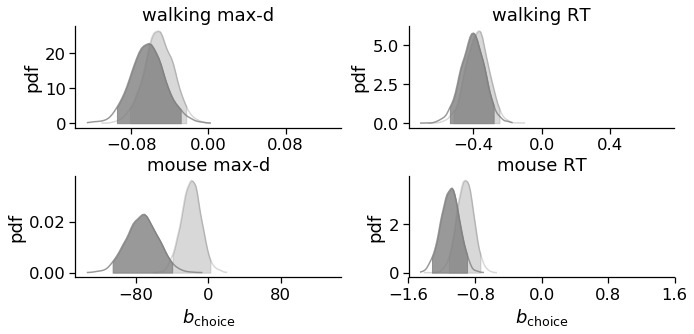

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(10,5))
plot_choice_posteriors('lambda', axes)

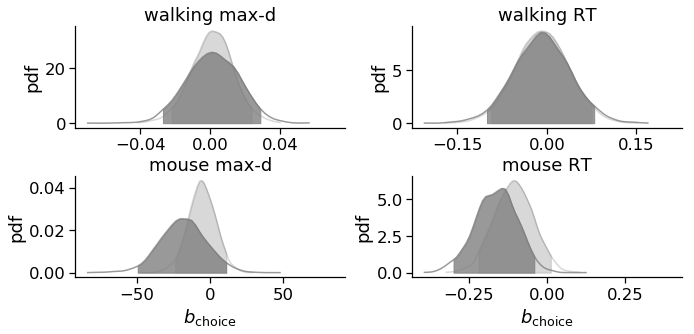

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(10,5))
plot_choice_posteriors('Delta', axes)

# Combine choice and Delta effects

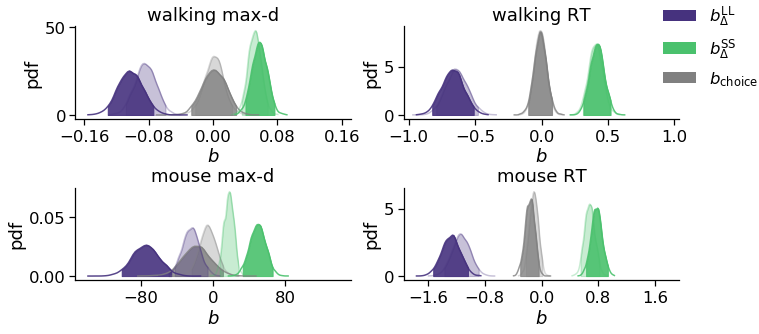

In [9]:
sns.set_palette('viridis')
sns.set_context("notebook", font_scale=1.5)

fig, axes = plt.subplots(2, 2, figsize=(10,5))
plot_choice_posteriors('Delta', axes)
plot_all_posteriors('Delta', axes, legend=False)

for ax in axes.flatten():
    ax.set_xlabel('$b$')
    
colors={'$b_{\Delta}^\mathrm{LL}$': 'C0', '$b_{\Delta}^\mathrm{SS}$': 'C4', '$b_{\mathrm{choice}}$': 'grey'}
legend_elements = [Patch(facecolor=color, label=b) for b, color in colors.items()]

fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.9, 0.8), ncol=1, frameon=False)
plt.tight_layout(pad=1.1, w_pad=0.1, h_pad=0.1)

plt.savefig(os.path.join(figure_path, 'posterior_Delta_combined' + figure_format), dpi=300, bbox_inches = 'tight')

# Descriptive statistics

Rate of changes-of-mind

In [76]:
len(choices_mouse[~choices_mouse.is_com])/len(choices_mouse)

0.9088353413654618

In [77]:
len(choices_walking[~choices_walking.is_com])/len(choices_walking)

0.9893920848633211

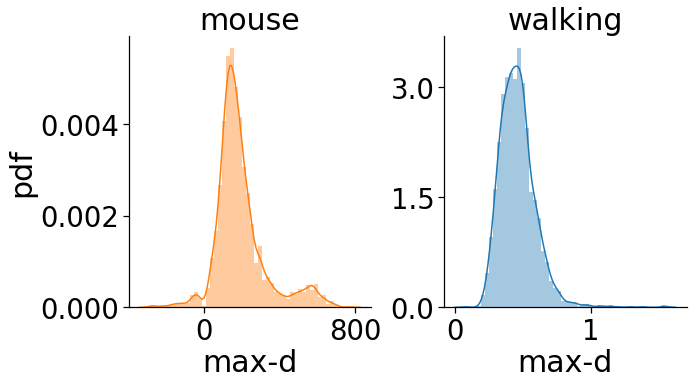

In [62]:
sns.set_palette("tab10")
sns.set_context("notebook", font_scale=2.5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5)) 

sns.distplot(choices_mouse.max_d, color='C1', ax=ax1)
ax1.set_xlabel('max-d')
ax1.set_ylabel('pdf')
ax1.set_title('mouse')

sns.distplot(choices_walking.max_d, color='C0', ax=ax2)
ax2.set_xlabel('max-d')
ax2.set_title('walking')

for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
plt.subplots_adjust(wspace=0.3)
plt.savefig(os.path.join(figure_path, 'max_d_distribution'+figure_format), bbox_inches='tight')

# Hypothesis 2

In [15]:
k_values_task, ip_task = helper.get_k_values(choices, by='task', log=False)
k_values_session, ip_session = helper.get_k_values(choices, by='session', log=False)

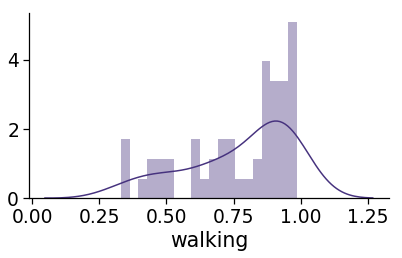

In [19]:
sns.distplot(k_values_task.walking, bins=20)

In [29]:
def plot_discounting_and_k_hist(k_diff, indifference_points, by, palette, colors, log=False):
    sns.set_palette(palette)
    sns.set_context('notebook', font_scale=1.6)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    sns.lineplot(data=indifference_points, x='ll_delay', y='indiff_point', hue=by, style=by, 
                     marker='o', ms=10, markers=True, palette=colors, ax=ax1)
    ax1.set_ylim(0, 0.9)
    ax1.set_xlabel('delay')
    ax1.set_ylabel('subjective value')
    ax1.get_legend().texts[0].set_text(by)
    
    if(log):
        ax1.set_xscale('log')
        
    sns.distplot(k_diff, bins=np.linspace(-0.4, 0.4, 20), color='k', norm_hist=False, kde=False, ax=ax2,
                hist_kws={'alpha': 0.2}, label='count')
    ax2.set_ylabel('count / pdf')
    ax2.axvline(0.0, alpha=0.3, color='k')
        
    return((ax1, ax2))  

def plot_k_posterior(samples, ax, alpha=0.3):
    kde = gaussian_kde(samples)
    x_grid = np.linspace(samples.min(), samples.max(), 51)

    ax.plot(x_grid, kde(x_grid), color='grey', alpha=alpha)

    ax.fill_between(x_grid, kde(x_grid), color='grey', alpha=alpha,
                    where=(x_grid>samples.quantile(0.025))&(x_grid<samples.quantile(0.975)), label='pdf')
    ax.legend(loc='upper right')

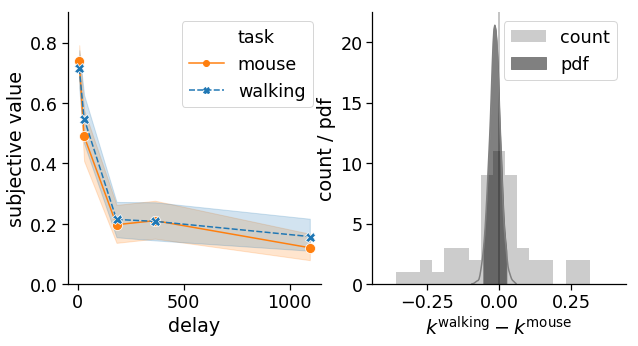

In [10]:
ax1, ax2 = plot_discounting_and_k_hist(k_diff = k_values_task['walking'] - k_values_task['mouse'], 
                                       indifference_points=ip_task, by='task', 
                                       palette='tab10', colors=['C1', 'C0'], log=False)

plot_k_posterior(samples=(pd.read_csv('posterior_csv/posterior_k_task_prereg.csv').loc[:, 'b_taskwalking']), 
                 ax=ax2, alpha=1.0)

ax2.set_xlabel(r'$k^{\mathrm{walking}}-k^{\mathrm{mouse}}$');
plt.savefig(os.path.join(figure_path, 'k_task_prereg'+figure_format))

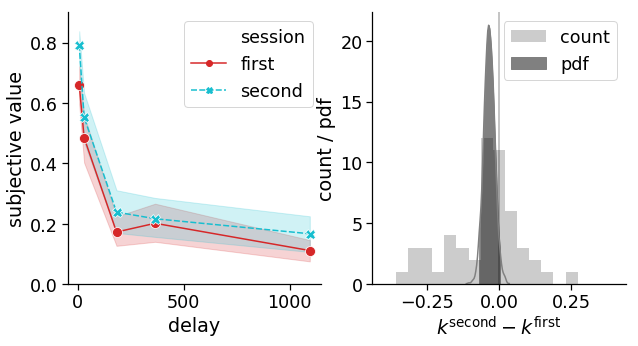

In [11]:
ax1, ax2 = plot_discounting_and_k_hist(k_diff = k_values_session['second'] - k_values_session['first'], 
                                       indifference_points=ip_session, by='session', 
                                       palette='tab10', colors=['C3', 'C9'], log=False)
plot_k_posterior(samples=(pd.read_csv('posterior_csv/posterior_k_session_prereg.csv').loc[:, 'b_sessionsecond']), 
                 ax=ax2, alpha=1.0)

ax2.set_xlabel(r'$k^{\mathrm{second}}-k^{\mathrm{first}}$');
plt.savefig(os.path.join(figure_path, 'k_session_prereg'+figure_format))

# Hypothesis 2 (exploratory)

In [21]:
k_values_task_log, ip_task = helper.get_k_values(choices, by='task', log=True)
k_values_session_log, ip_session = helper.get_k_values(choices, by='session', log=True)

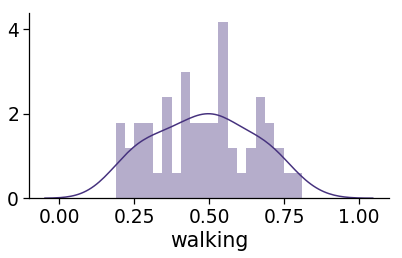

In [22]:
sns.distplot(k_values_task_log.walking, bins=20)

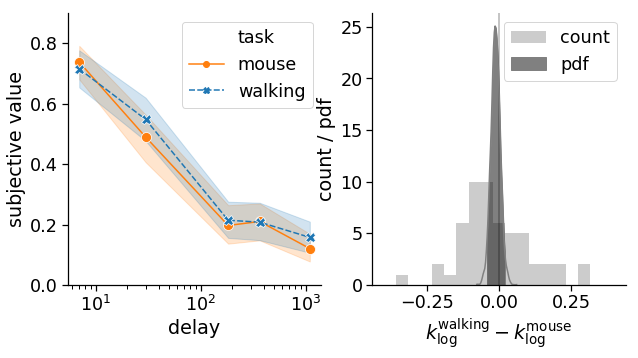

In [68]:
ax1, ax2 = plot_discounting_and_k_hist(k_diff = k_values_task_log['walking'] - k_values_task_log['mouse'], 
                                       indifference_points=ip_task, by='task', 
                                       palette='tab10', colors=['C1', 'C0'], log=True)
plot_k_posterior(samples=(pd.read_csv('posterior_csv/posterior_k_task_log_delay.csv').loc[:, 'b_taskwalking']), 
                 ax=ax2, alpha=1.0)

ax2.set_xlabel(r'$k_{\log}^{\mathrm{walking}}-k_{\log}^{\mathrm{mouse}}$');
plt.savefig(os.path.join(figure_path, 'k_task_log'+figure_format))

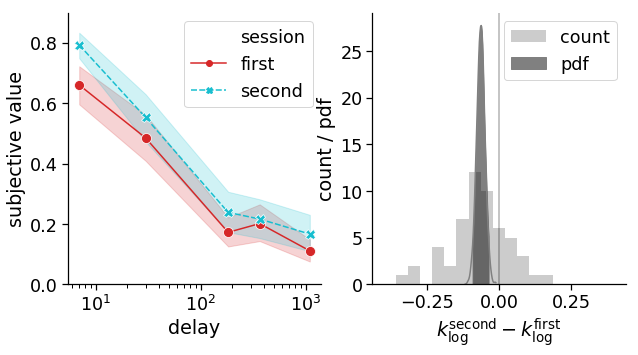

In [69]:
ax1, ax2 = plot_discounting_and_k_hist(k_diff = k_values_session_log['second'] - k_values_session_log['first'], 
                                       indifference_points=ip_session, by='session', 
                                       palette='tab10', colors=['C3', 'C9'], log=True)
plot_k_posterior(samples=(pd.read_csv('posterior_csv/posterior_k_session_log_delay.csv').loc[:, 'b_sessionsecond']), 
                 ax=ax2, alpha=1.0)
ax2.set_xlabel(r'$k_{\log}^{\mathrm{second}}-k_{\log}^{\mathrm{first}}$');
plt.savefig(os.path.join(figure_path, 'k_session_log'+figure_format))

In [37]:
from scipy import stats

def print_ttest_results(x):
    print(stats.ttest_1samp(x, 0))
    print('Effect size %.4f' % (x.mean()/x.std()))

print_ttest_results(k_values_task_log['walking'] - k_values_task_log['mouse'])
print_ttest_results(k_values_session_log['second'] - k_values_session_log['first'])

Ttest_1sampResult(statistic=-0.9855037464101619, pvalue=0.3328165839365569)
Effect size -0.1830


# Number of changes-of-minds

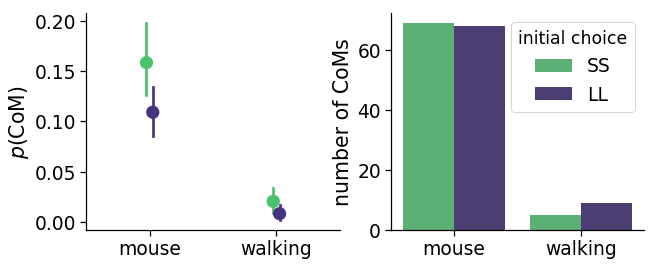

In [21]:
def plot_n_com(choices):
    sns.set_palette('viridis')
    sns.set_context('notebook', font_scale=1.7)

    choices['is_SS_initially'] = (choices['choice'] == 'SS')
    choices.loc[choices.is_com, 'is_SS_initially'] = ~choices.loc[choices.is_com, 'is_SS_initially']
    choices['initial_choice'] = 'LL'
    choices.loc[choices.is_SS_initially, 'initial_choice'] = 'SS'

    fig = plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], figure=fig)

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    sns.pointplot(data=choices[choices.is_staircase], x='task', y='is_com', hue='initial_choice', scale=1.5,
                  palette=['C4', 'C0'], join=False, dodge=True, ax=ax1)
    ax1.get_legend().remove()
    ax1.set_xlabel('')
    ax1.set_ylabel('$p(\mathrm{CoM})$')
    # sns.despine(bottom=True)

    sns.countplot(data=choices[choices.is_com & choices.is_staircase], x='task', hue='initial_choice', 
                       palette=['C4', 'C0'], saturation=0.7, ax=ax2)
    ax2.get_legend().set_title('initial choice')
    ax2.set_xlabel('')
    ax2.set_ylabel('number of CoMs')
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plot_n_com(choices)
plt.savefig(os.path.join(figure_path, 'com_freq'+figure_format))

### Try separating subjects into weak and strong discounters

In [23]:
choices = choices.join((choices.groupby('subj_id').ss_chosen.mean()>0.6).rename('is_strong_discounter'))

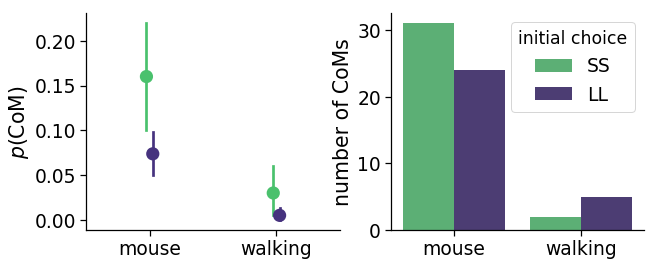

In [31]:
plot_n_com(choices[choices.is_strong_discounter])
plt.savefig(os.path.join(figure_path, 'strong_discounters_com_freq'+figure_format))

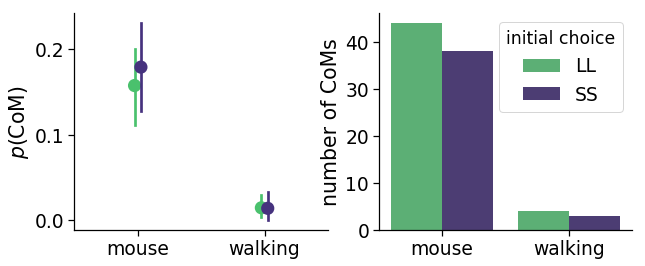

In [32]:
plot_n_com(choices[~choices.is_strong_discounter])
plt.savefig(os.path.join(figure_path, 'weak_discounters_com_freq'+figure_format))

Ttest_1sampResult(statistic=-0.9855037464101619, pvalue=0.3328165839365569)
Effect size -0.1830


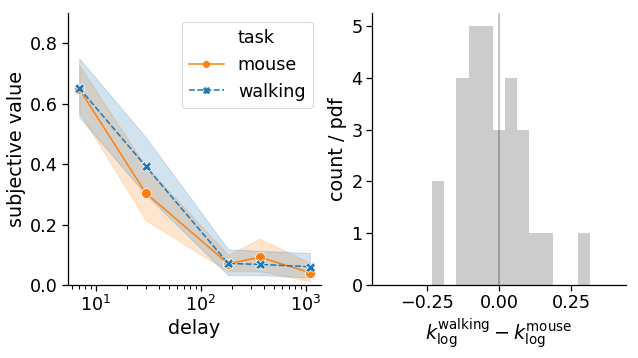

In [38]:
k_values_task_log, ip_task = helper.get_k_values(choices[choices.is_strong_discounter], by='task', log=True)

ax1, ax2 = plot_discounting_and_k_hist(k_diff = k_values_task_log['walking'] - k_values_task_log['mouse'], 
                                       indifference_points=ip_task, by='task', 
                                       palette='tab10', colors=['C1', 'C0'], log=True)
ax2.set_xlabel(r'$k_{\log}^{\mathrm{walking}}-k_{\log}^{\mathrm{mouse}}$');
plt.savefig(os.path.join(figure_path, 'strong_discounters_curve'+figure_format))
print_ttest_results(k_values_task_log['walking'] - k_values_task_log['mouse'])

Ttest_1sampResult(statistic=-0.24538456501908104, pvalue=0.8082448563480715)
Effect size -0.0491


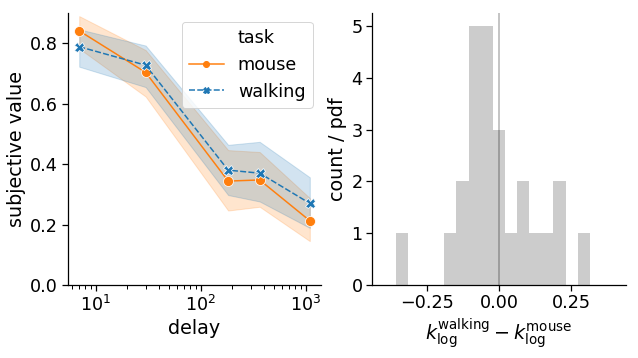

In [39]:
k_values_task_log, ip_task = helper.get_k_values(choices[~choices.is_strong_discounter], by='task', log=True)

ax1, ax2 = plot_discounting_and_k_hist(k_diff = k_values_task_log['walking'] - k_values_task_log['mouse'], 
                                       indifference_points=ip_task, by='task', 
                                       palette='tab10', colors=['C1', 'C0'], log=True)
ax2.set_xlabel(r'$k_{\log}^{\mathrm{walking}}-k_{\log}^{\mathrm{mouse}}$');
plt.savefig(os.path.join(figure_path, 'weak_discounters_curve'+figure_format))
print_ttest_results(k_values_task_log['walking'] - k_values_task_log['mouse'])

# Other plots

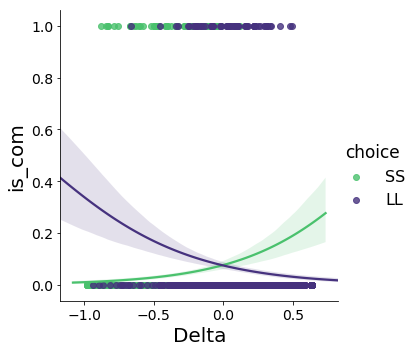

In [21]:
sns.set_palette('viridis')
sns.lmplot(data=choices, x='Delta', y='is_com', hue='choice', palette=['C4', 'C0'], logistic=True)

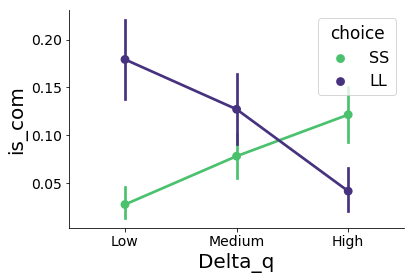

In [35]:
sns.pointplot(data=choices_mouse, x='Delta_q', y='is_com', hue='choice', palette=['C4', 'C0'])

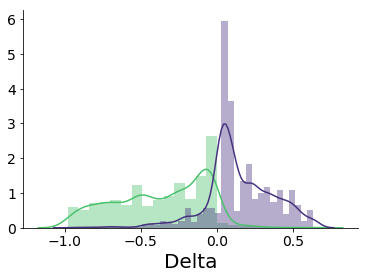

In [31]:
sns.distplot(choices.loc[(choices.choice=='SS'), 'Delta'], color='C4')
sns.distplot(choices.loc[(choices.choice=='LL'), 'Delta'], color='C0')

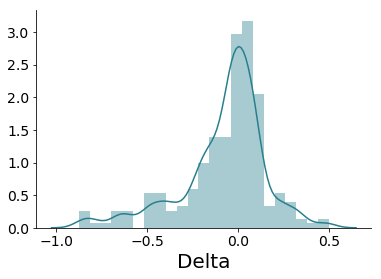

In [32]:
sns.distplot(choices.loc[(choices.is_com), 'Delta'], color='C2')

In [13]:
print(choices.groupby(['choice']).size()/len(choices))

choice
LL    0.405384
SS    0.594616
dtype: float64


In [14]:
def print_choice_distribution(choices):
    print(choices.groupby(['task', 'choice']).size()/choices.groupby(['task']).size())
    print(choices[~choices.is_com].groupby(['task', 'choice']).size()/choices[~choices.is_com].groupby(['task']).size())
    print(choices[choices.is_com].groupby(['task', 'choice']).size()/choices[choices.is_com].groupby(['task']).size())

In [5]:
print_choice_distribution(choices = choices[choices.is_staircase])

task     choice
mouse    LL        0.405278
         SS        0.594722
walking  LL        0.418357
         SS        0.581643
dtype: float64
task     choice
mouse    LL        0.390693
         SS        0.609307
walking  LL        0.419197
         SS        0.580803
dtype: float64
task     choice
mouse    LL        0.503650
         SS        0.496350
walking  LL        0.357143
         SS        0.642857
dtype: float64


# Choice distribution

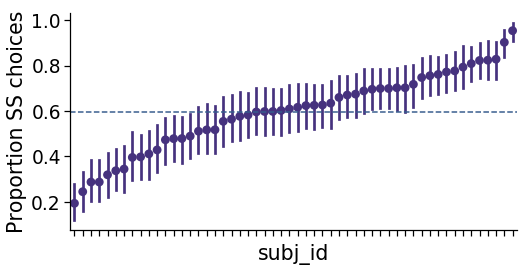

In [5]:
fig, ax = plt.subplots(figsize = (8, 4))
subj_order = choices.groupby('subj_id').ss_chosen.mean().sort_values().reset_index().subj_id
sns.pointplot(data=choices, x='subj_id', y='ss_chosen', order=subj_order, join=False, ax=ax)
ax.axhline(choices.ss_chosen.mean(), ls='--', color='C1')
ax.set_xticklabels([])
ax.set_ylabel('subject')
ax.set_ylabel('Proportion SS choices');
plt.savefig(os.path.join(figure_path, 'proportion_ss'+figure_format))

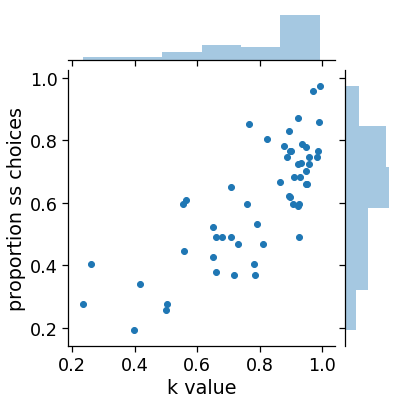

In [13]:
g = sns.jointplot(k_values_task.mouse, choices_mouse.groupby('subj_id').mean()['ss_chosen'])
g.ax_joint.set_xlabel('k value')
g.ax_joint.set_ylabel('proportion ss choices')
plt.savefig(os.path.join(figure_path, 'k_vs_p_ss'+figure_format))

In [7]:
choices.groupby(['task', 'initial_choice']).apply(lambda c: len(c[c.is_com])/len(c))

task     initial_choice
mouse    LL                0.115972
         SS                0.074983
walking  LL                0.013685
         SS                0.008403
dtype: float64

In [53]:
com_count = choices[(choices.is_com) & (choices.task=='mouse')].groupby(['subj_id', 'choice']).size().unstack().fillna(0)

In [54]:
com_count['total'] = com_count.LL + com_count.SS
com_count['proportion_SS'] = com_count.SS/com_count.total
com_count = com_count[com_count.total>2]

Ttest_1sampResult(statistic=0.29885394413604266, pvalue=0.7718371156116056)
Effect size 0.0945


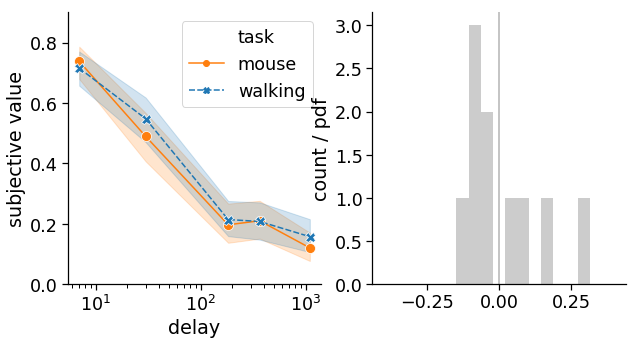

In [55]:
k_values_task_log_com_LL = k_values_task_log[k_values_task_log.subj_id.isin(com_count[(com_count.proportion_SS<0.5)].index)]

print_ttest_results(k_values_task_log_com_LL['walking'] - k_values_task_log_com_LL['mouse'])
ax1, ax2 = plot_discounting_and_k_hist(k_diff = k_values_task_log_com_LL['walking'] - k_values_task_log_com_LL['mouse'], 
                                       indifference_points=ip_task, by='task', 
                                       palette='tab10', colors=['C1', 'C0'], log=True)

Ttest_1sampResult(statistic=0.2762631219022257, pvalue=0.7903246851120446)
Effect size 0.0977


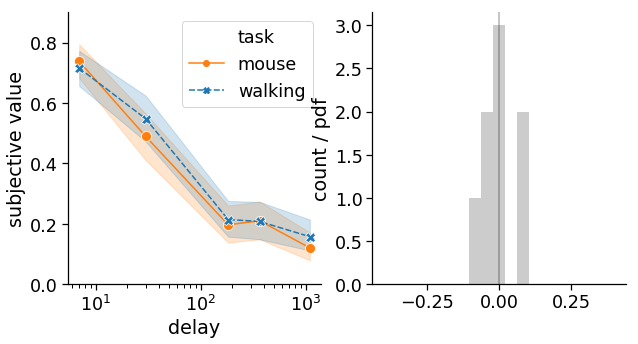

In [56]:
k_values_task_log_com_SS = k_values_task_log[k_values_task_log.subj_id.isin(com_count[(com_count.proportion_SS>0.5)].index)]

print_ttest_results(k_values_task_log_com_SS['walking'] - k_values_task_log_com_SS['mouse'])
ax1, ax2 = plot_discounting_and_k_hist(k_diff = k_values_task_log_com_SS['walking'] - k_values_task_log_com_SS['mouse'], 
                                       indifference_points=ip_task, by='task', 
                                       palette='tab10', colors=['C1', 'C0'], log=True)

In [5]:
choices_mouse.RT.mean()

2.764897991967862

In [6]:
choices_walking.RT.mean()

4.862441860465128

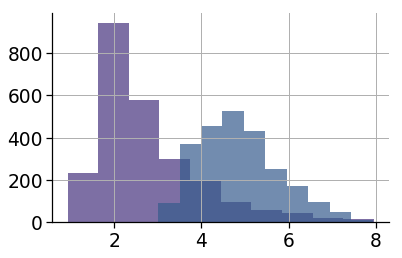

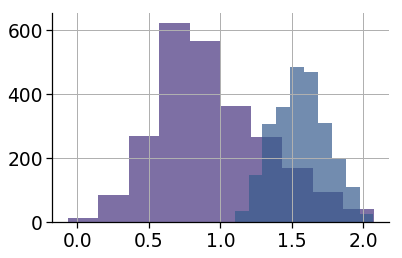

In [187]:
choices_mouse.RT.hist(alpha=0.7)
choices_walking.RT.hist(alpha=0.7)
plt.figure()
np.log(choices_mouse.RT).hist(alpha=0.7)
np.log(choices_walking.RT).hist(alpha=0.7)